In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
library(stringr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Least squares
The folder ElectionsEconomy contains the data for the example in Section 7.1.
Load these data, type in the R function `rss()` from page 104, and evaluate it at several different values of $ (a, b) $.
Make two graphs: a plot of the sum of squares of residuals as a funciton of $a$, with $b$ fixed at its least squares estimate given in Section 7.1, and a plot of the sum of squares of residuals as a function of $ b$, with $a$ fixed at its least squares estimate.
Confirm that the residual sum of squares is indeed minimized at the least squares estimate.

## Read the data

In [4]:
filename <- "./data/ElectionsEconomy/hibbs.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat')
hibbs <- read.table("./data/ElectionsEconomy/hibbs.dat", header=TRUE)

## Calculate the rss of different fits

In [5]:
rss <- function(x, y, a, b) {
    resid <- y - (a + b * x)
    sum(resid^2)
}

In [6]:
as <- seq(0, 100, by=0.1)
bs <- seq(0, 10, by=0.01)

In [7]:
rss_fits <- expand.grid(a=as, b=bs) %>% rowwise() %>% mutate(resid = rss(hibbs$growth, hibbs$vote, a, b))

## Find the minimiser of rss

In [8]:
min_rss <- rss_fits %>% arrange(resid) %>% head(1)

In [9]:
a_min = min_rss$a[1]
b_min = min_rss$b[1]
c(a_min, b_min)

[1] 46.20  3.08

## Plot residuals as function of a

It's a parabola

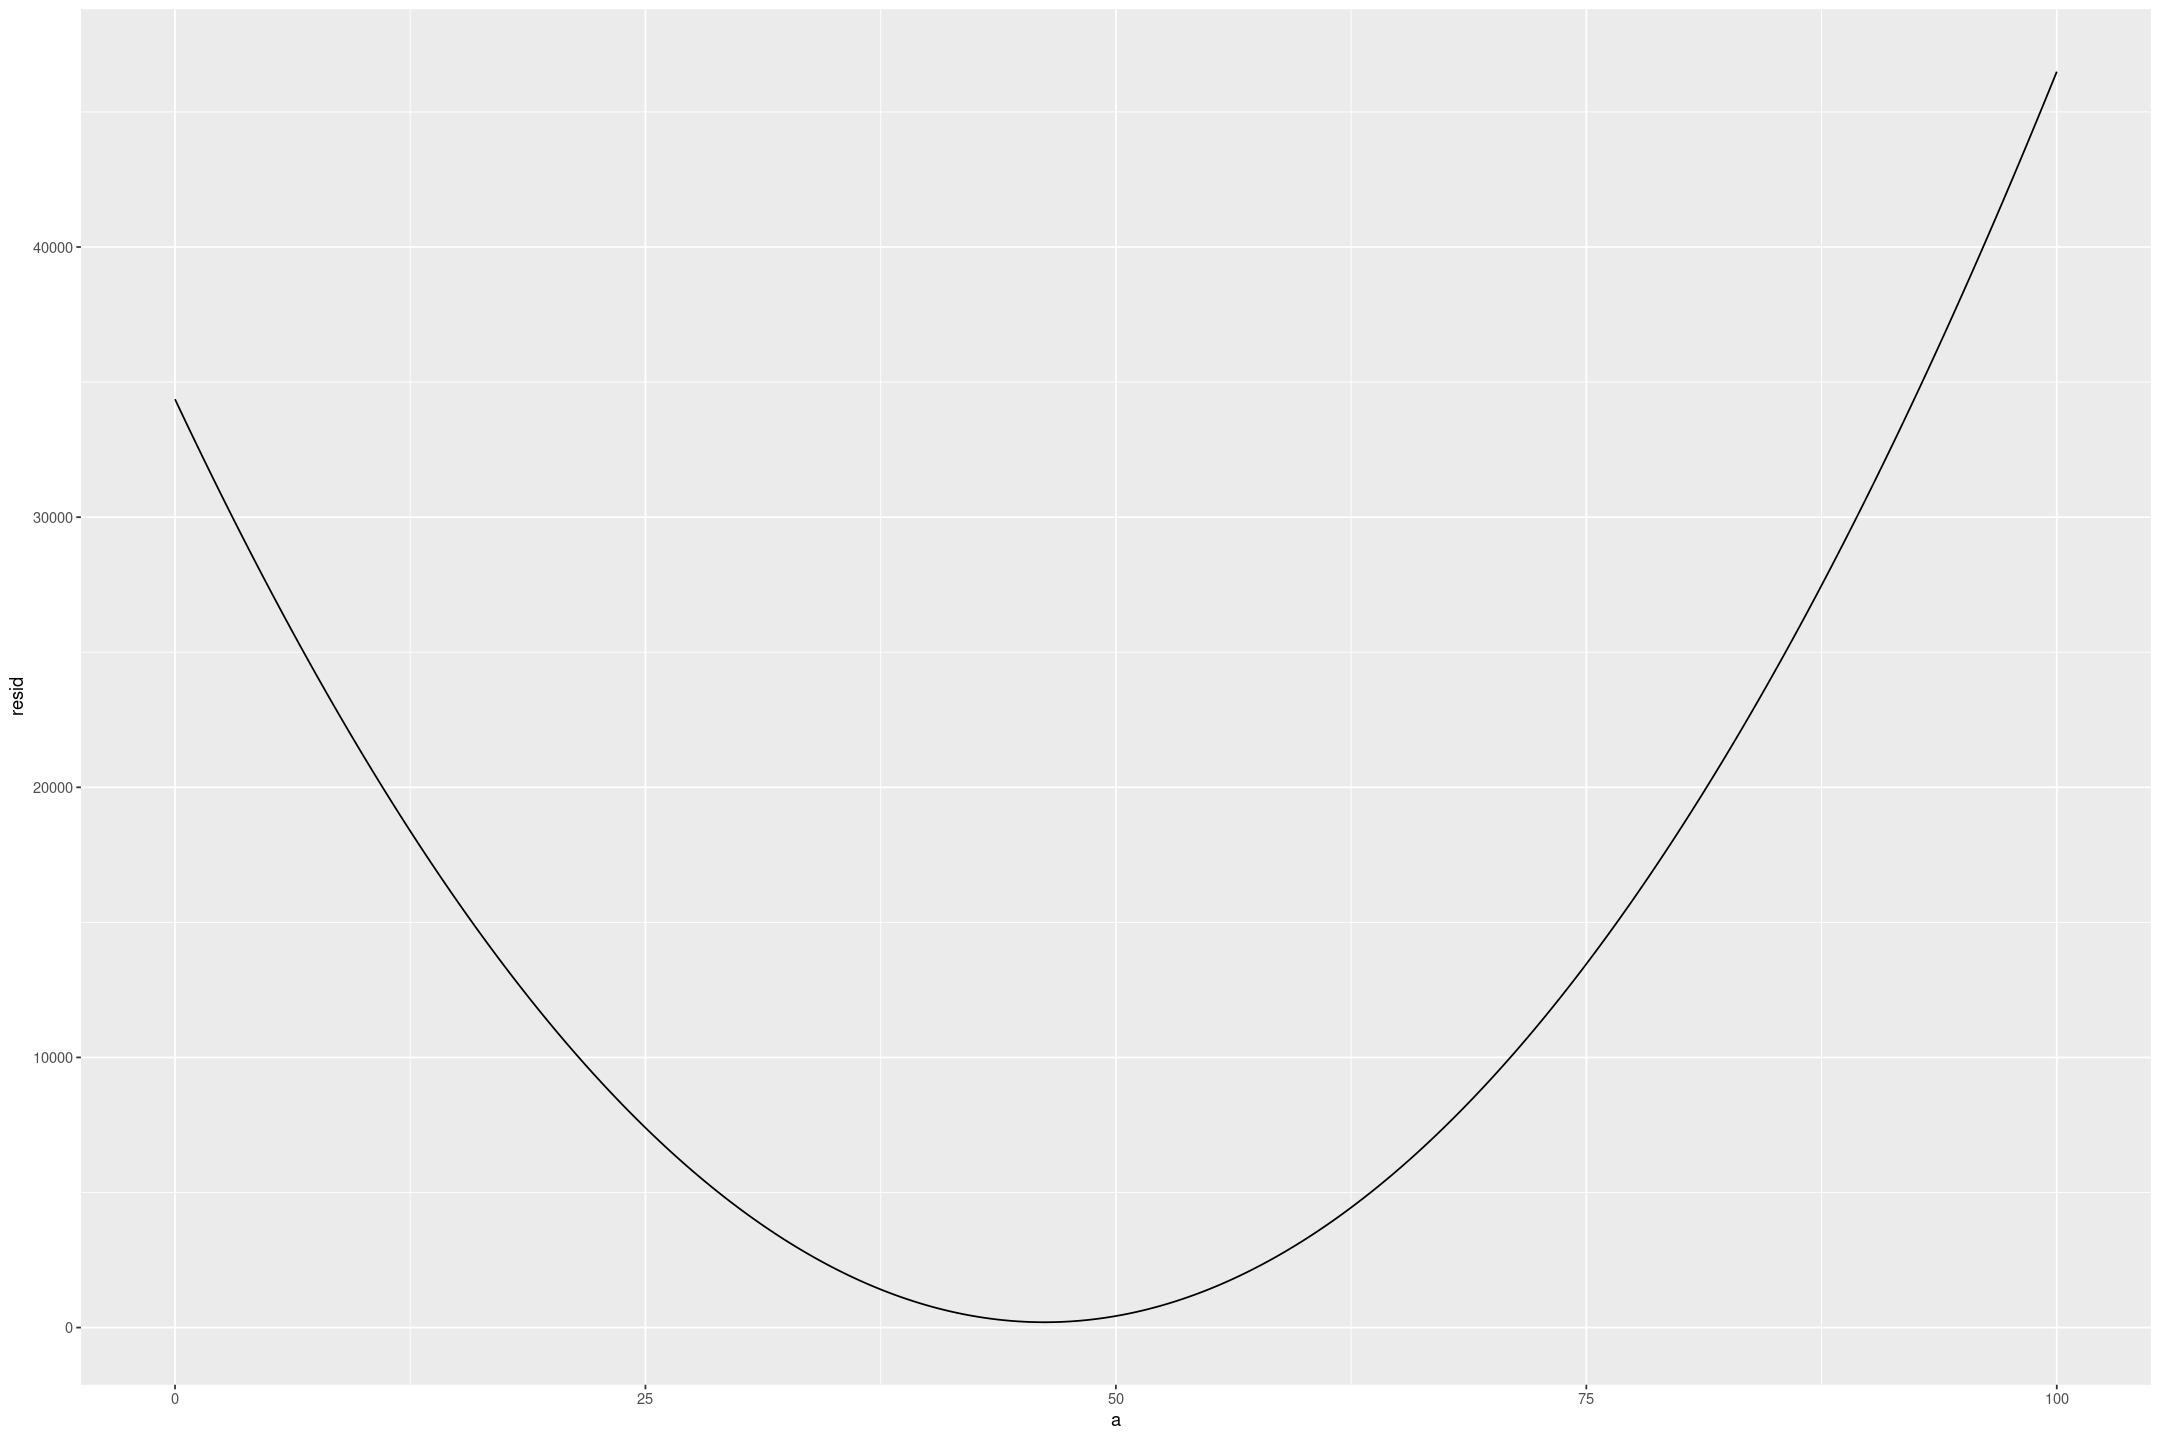

In [10]:
rss_fits %>% filter(b == b_min) %>% gf_line(resid ~ a)

## Plot residuals as function of b

It's another parabola

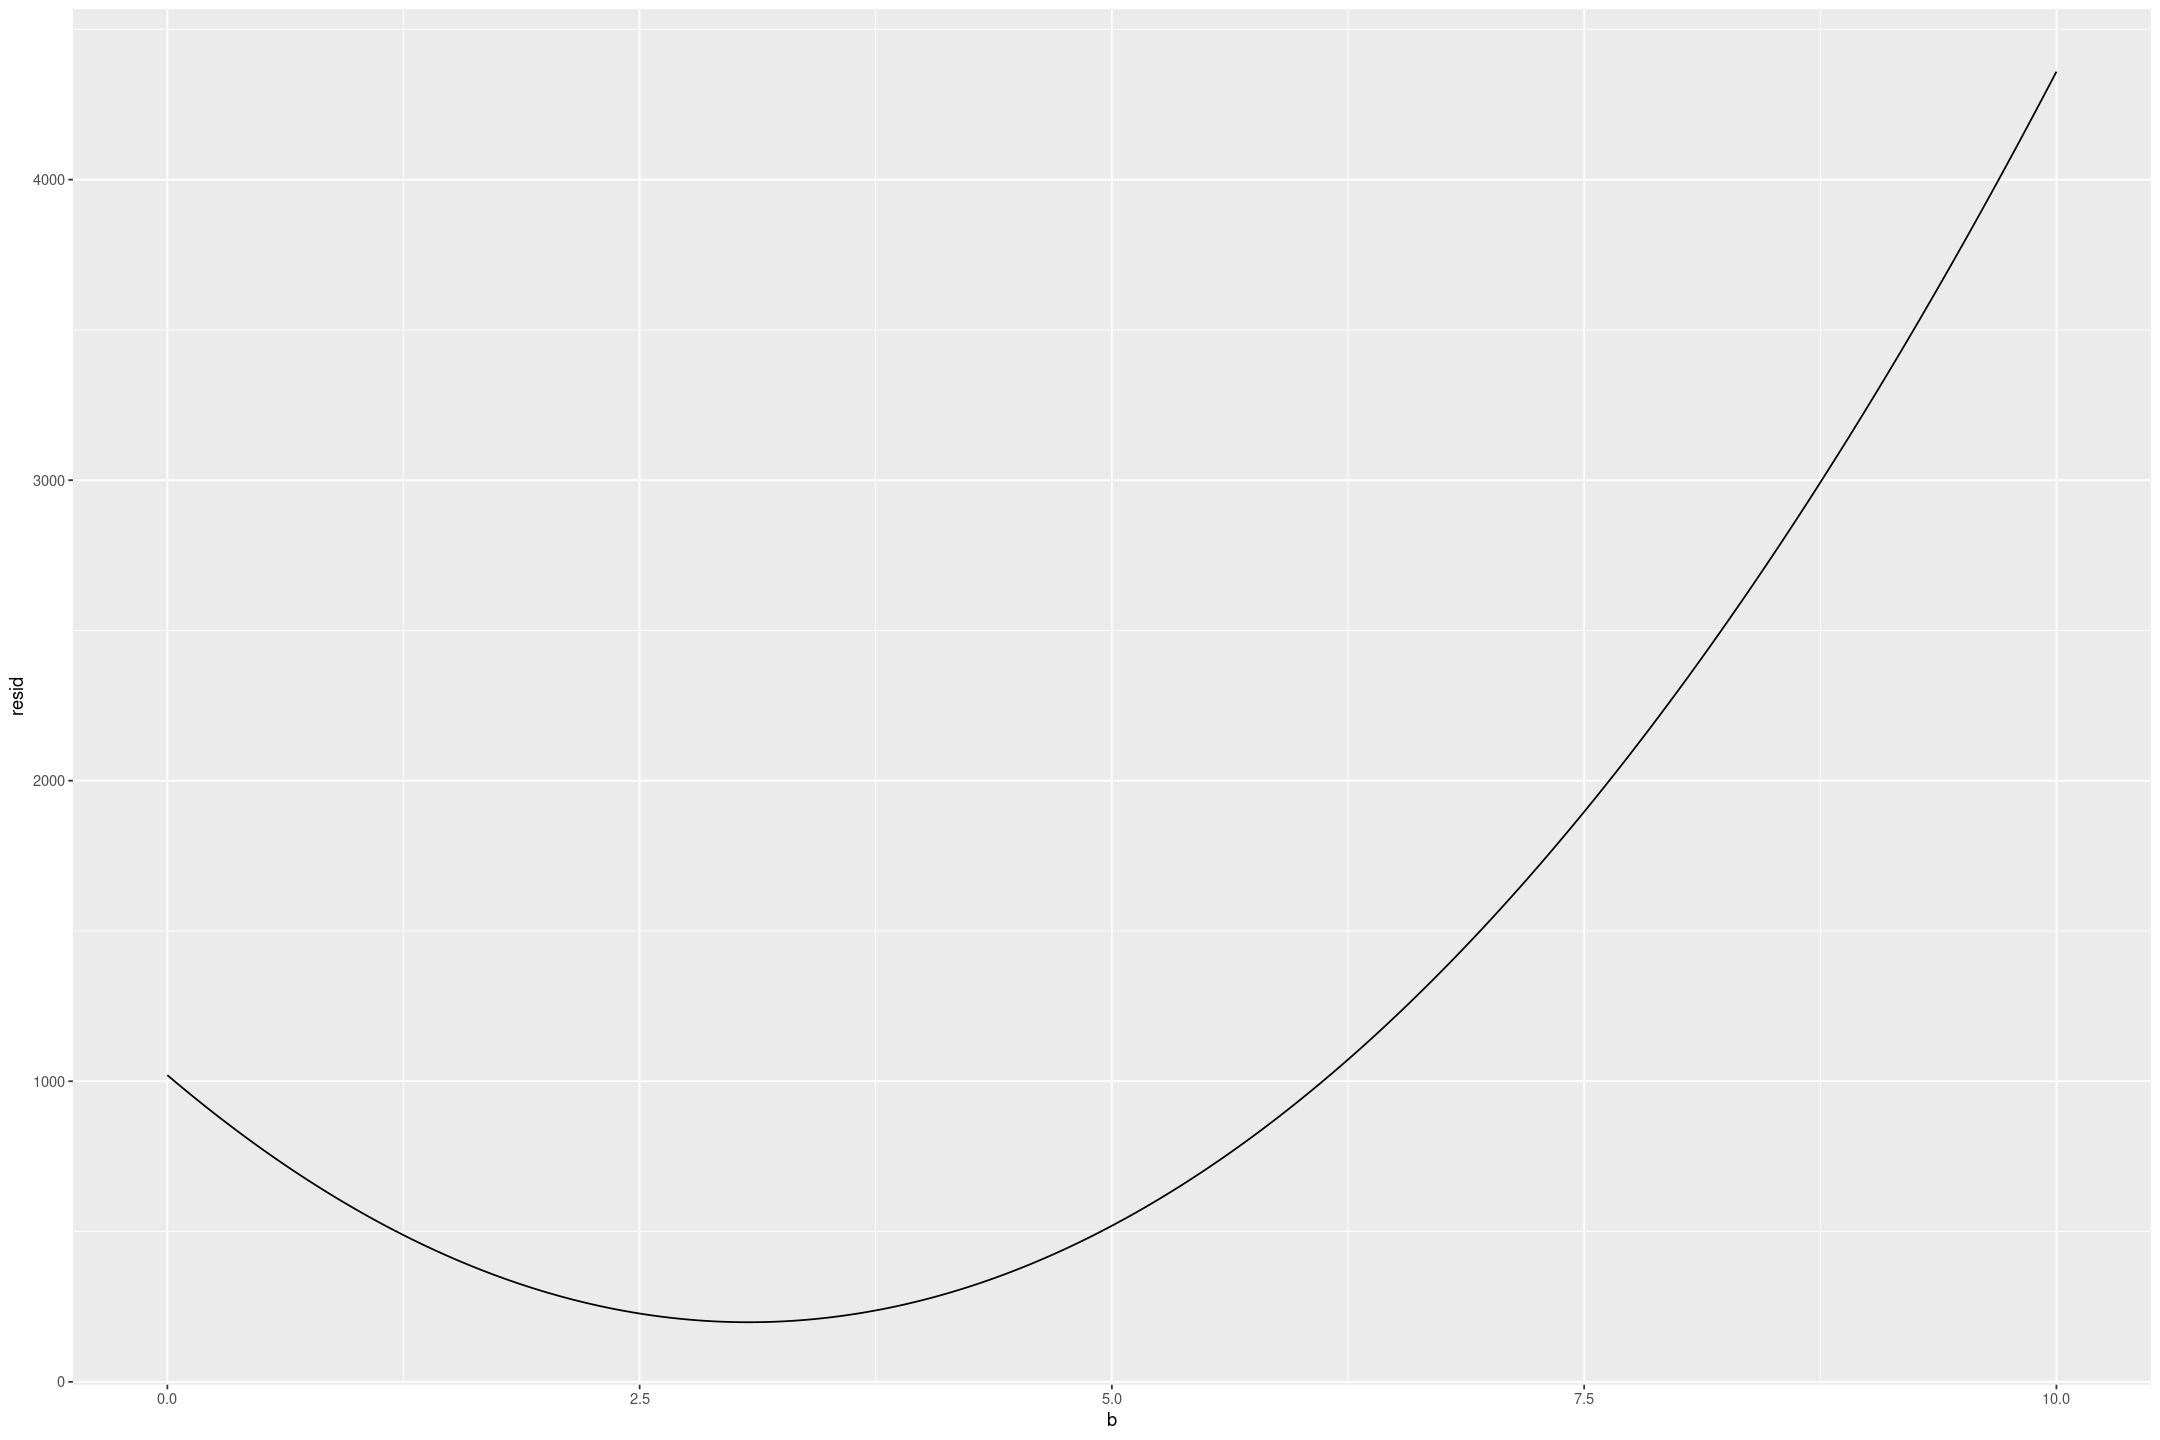

In [11]:
rss_fits %>% filter(a == a_min) %>% gf_line(resid ~ b)

## Combining the plots

It looks like a parabolic surface

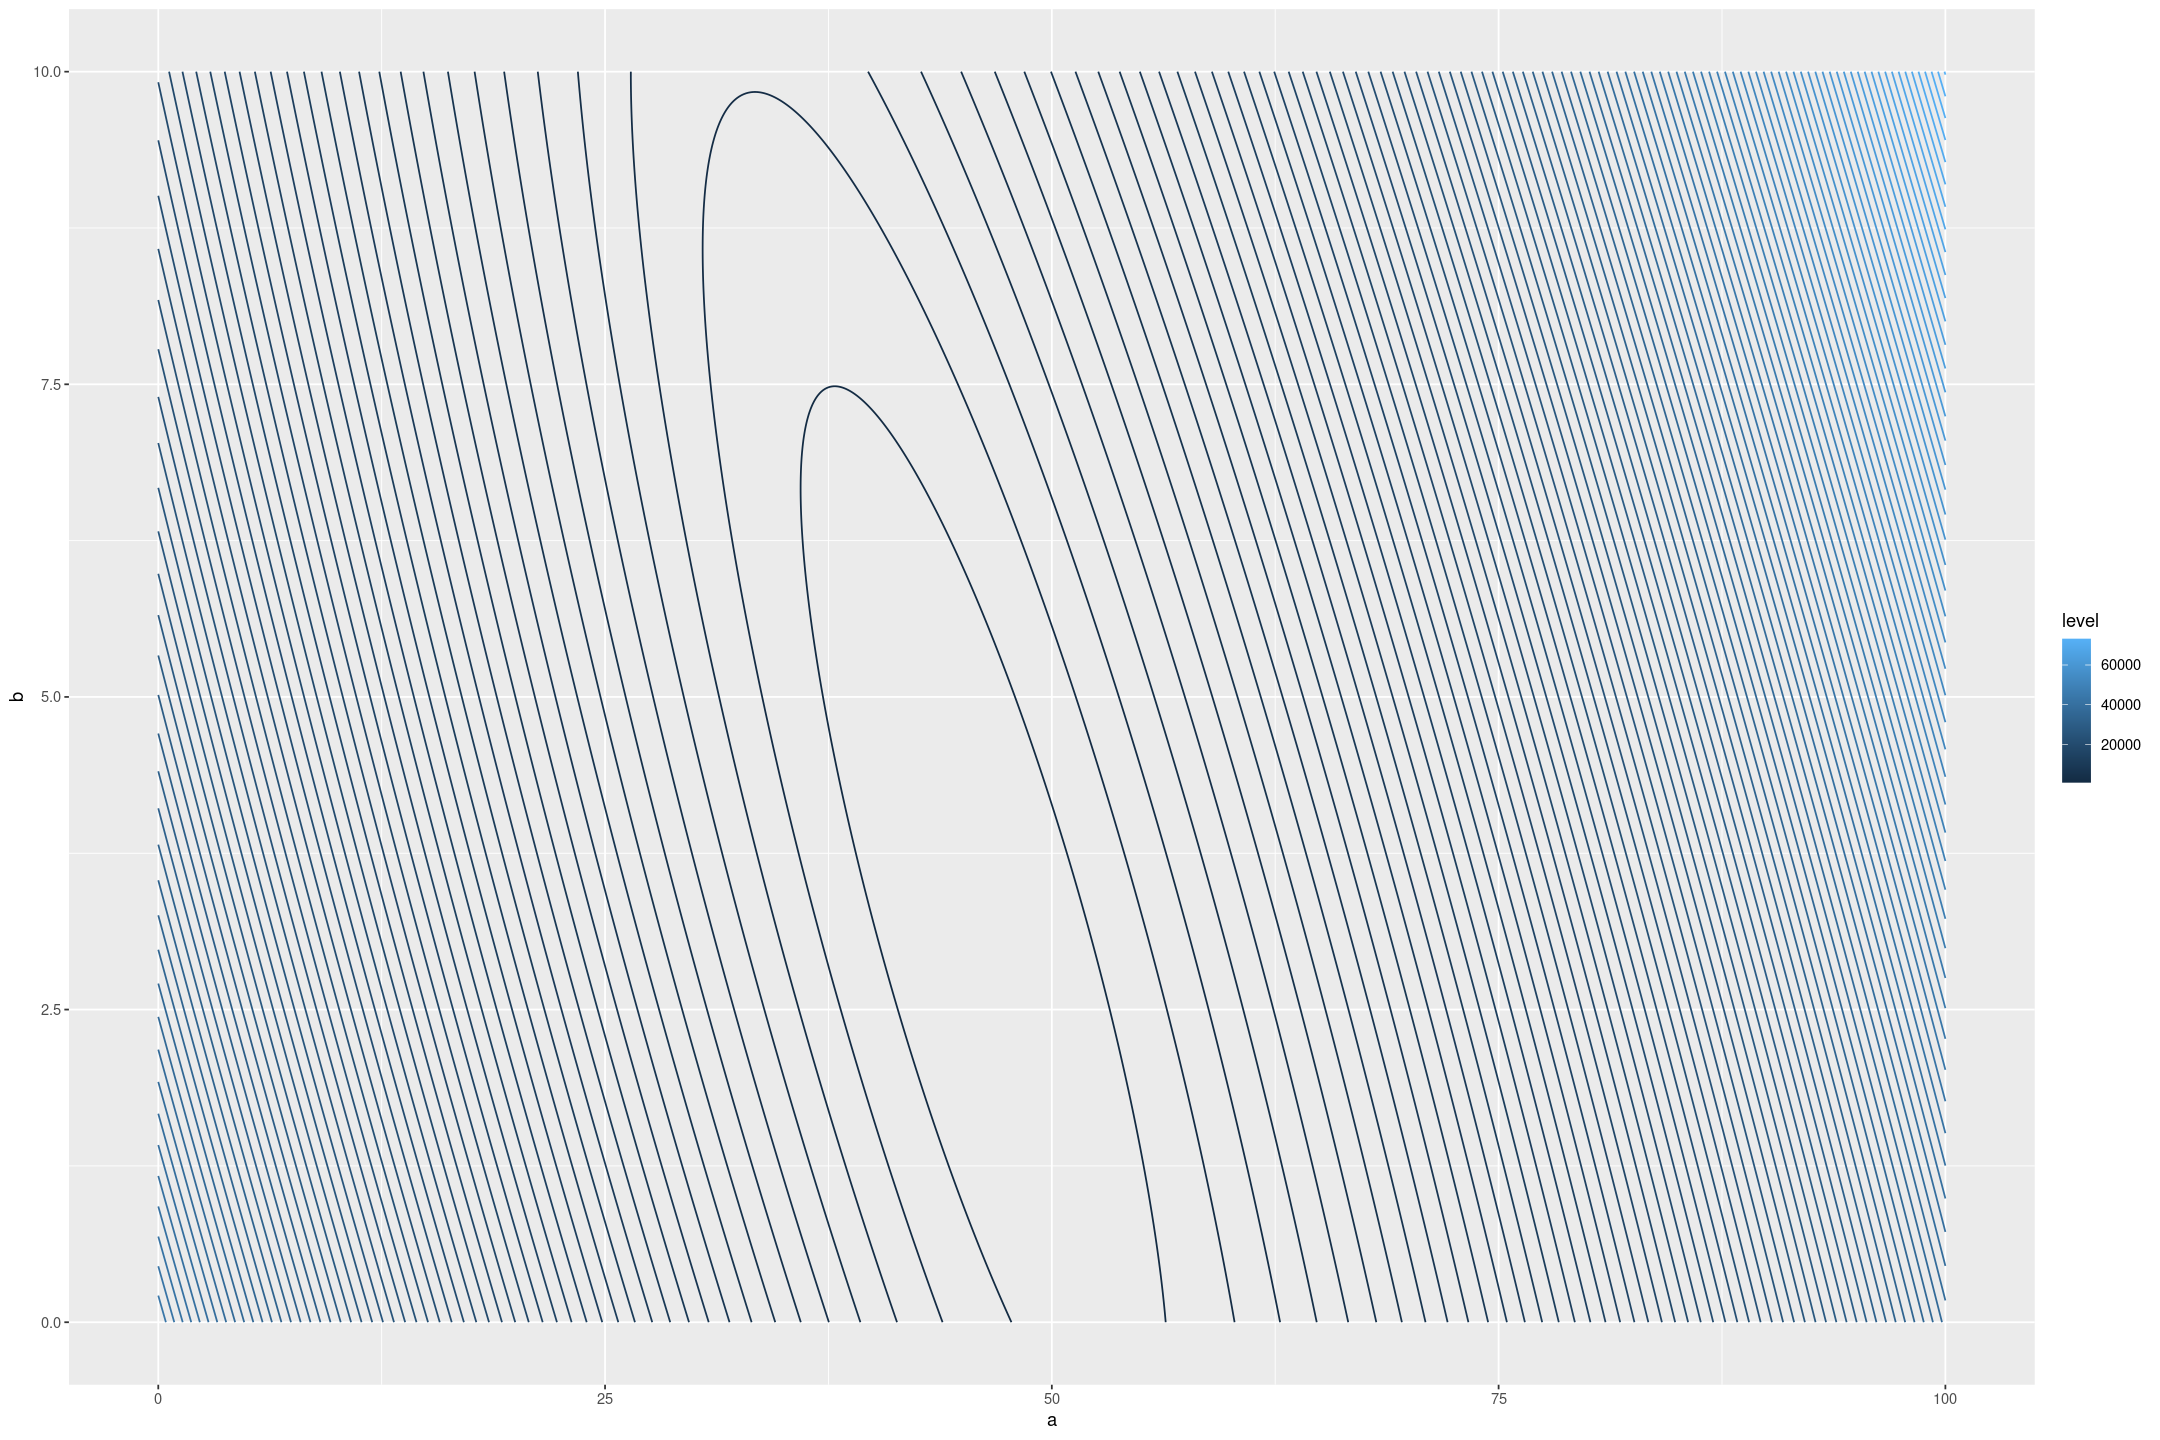

In [12]:
rss_fits %>% ggplot(mapping=aes(x=a, y=b, z=resid)) + 
geom_contour(bins=100, aes(colour = after_stat(level)))

# Maximum likelihood
Repeat the previous exercise but this time write a function, similar to `rss()` on page 104, that computes the logarithm of the likelihood (8.6) as a function of the data and the parameters $ a, b, \sigma$.
Evaluate this function at several values of these parameters, and make a plot demonstrating that it is maximized at the values computed from the formulas in the text (with $\sigma$ computed using $\frac{1}{n}$, not $\frac{1}{n-2}$; see page 104).

## Define the Log Likelihood function

In [13]:
normal_logliklihood <- function(x, y, a, b, sigma) {
    ypred <- a + b*x
    N <- length(y)
    - N * log(sigma) - sum((y - ypred)^2)/(2 * sigma^2) - N/2 * log(2*pi)
}

### Check a random point

In [14]:
normal_logliklihood(0.8, 1, 0.5, 0.2, 0.1)

[1] -4.396353

In [15]:
log(dnorm(1, 0.5 + 0.2*0.8, 0.1))

[1] -4.396353

In [16]:
normal_logliklihood(c(0.8, 0.8), c(1,1), 0.5, 0.2, 0.1)

[1] -8.792707

## Check the parameters are at the maximum loglikelihood

Equations from p 104

In [17]:
x <- hibbs$growth
y <- hibbs$vote

b_min <- sum((x - mean(x)) * y) / sum((x-mean(x))^2)
a_min <- mean(y) - b_min * mean(x)
s_min <- (1/length(y) * sum((y - (a_min + b_min * x))^2))^(1/2)

In [18]:
c(a_min, b_min, s_min)

[1] 46.247648  3.060528  3.520233

In [19]:
max_ll <- normal_logliklihood(hibbs$growth, hibbs$vote, a_min, b_min, s_min)
max_ll

[1] -42.83945

## Check along a

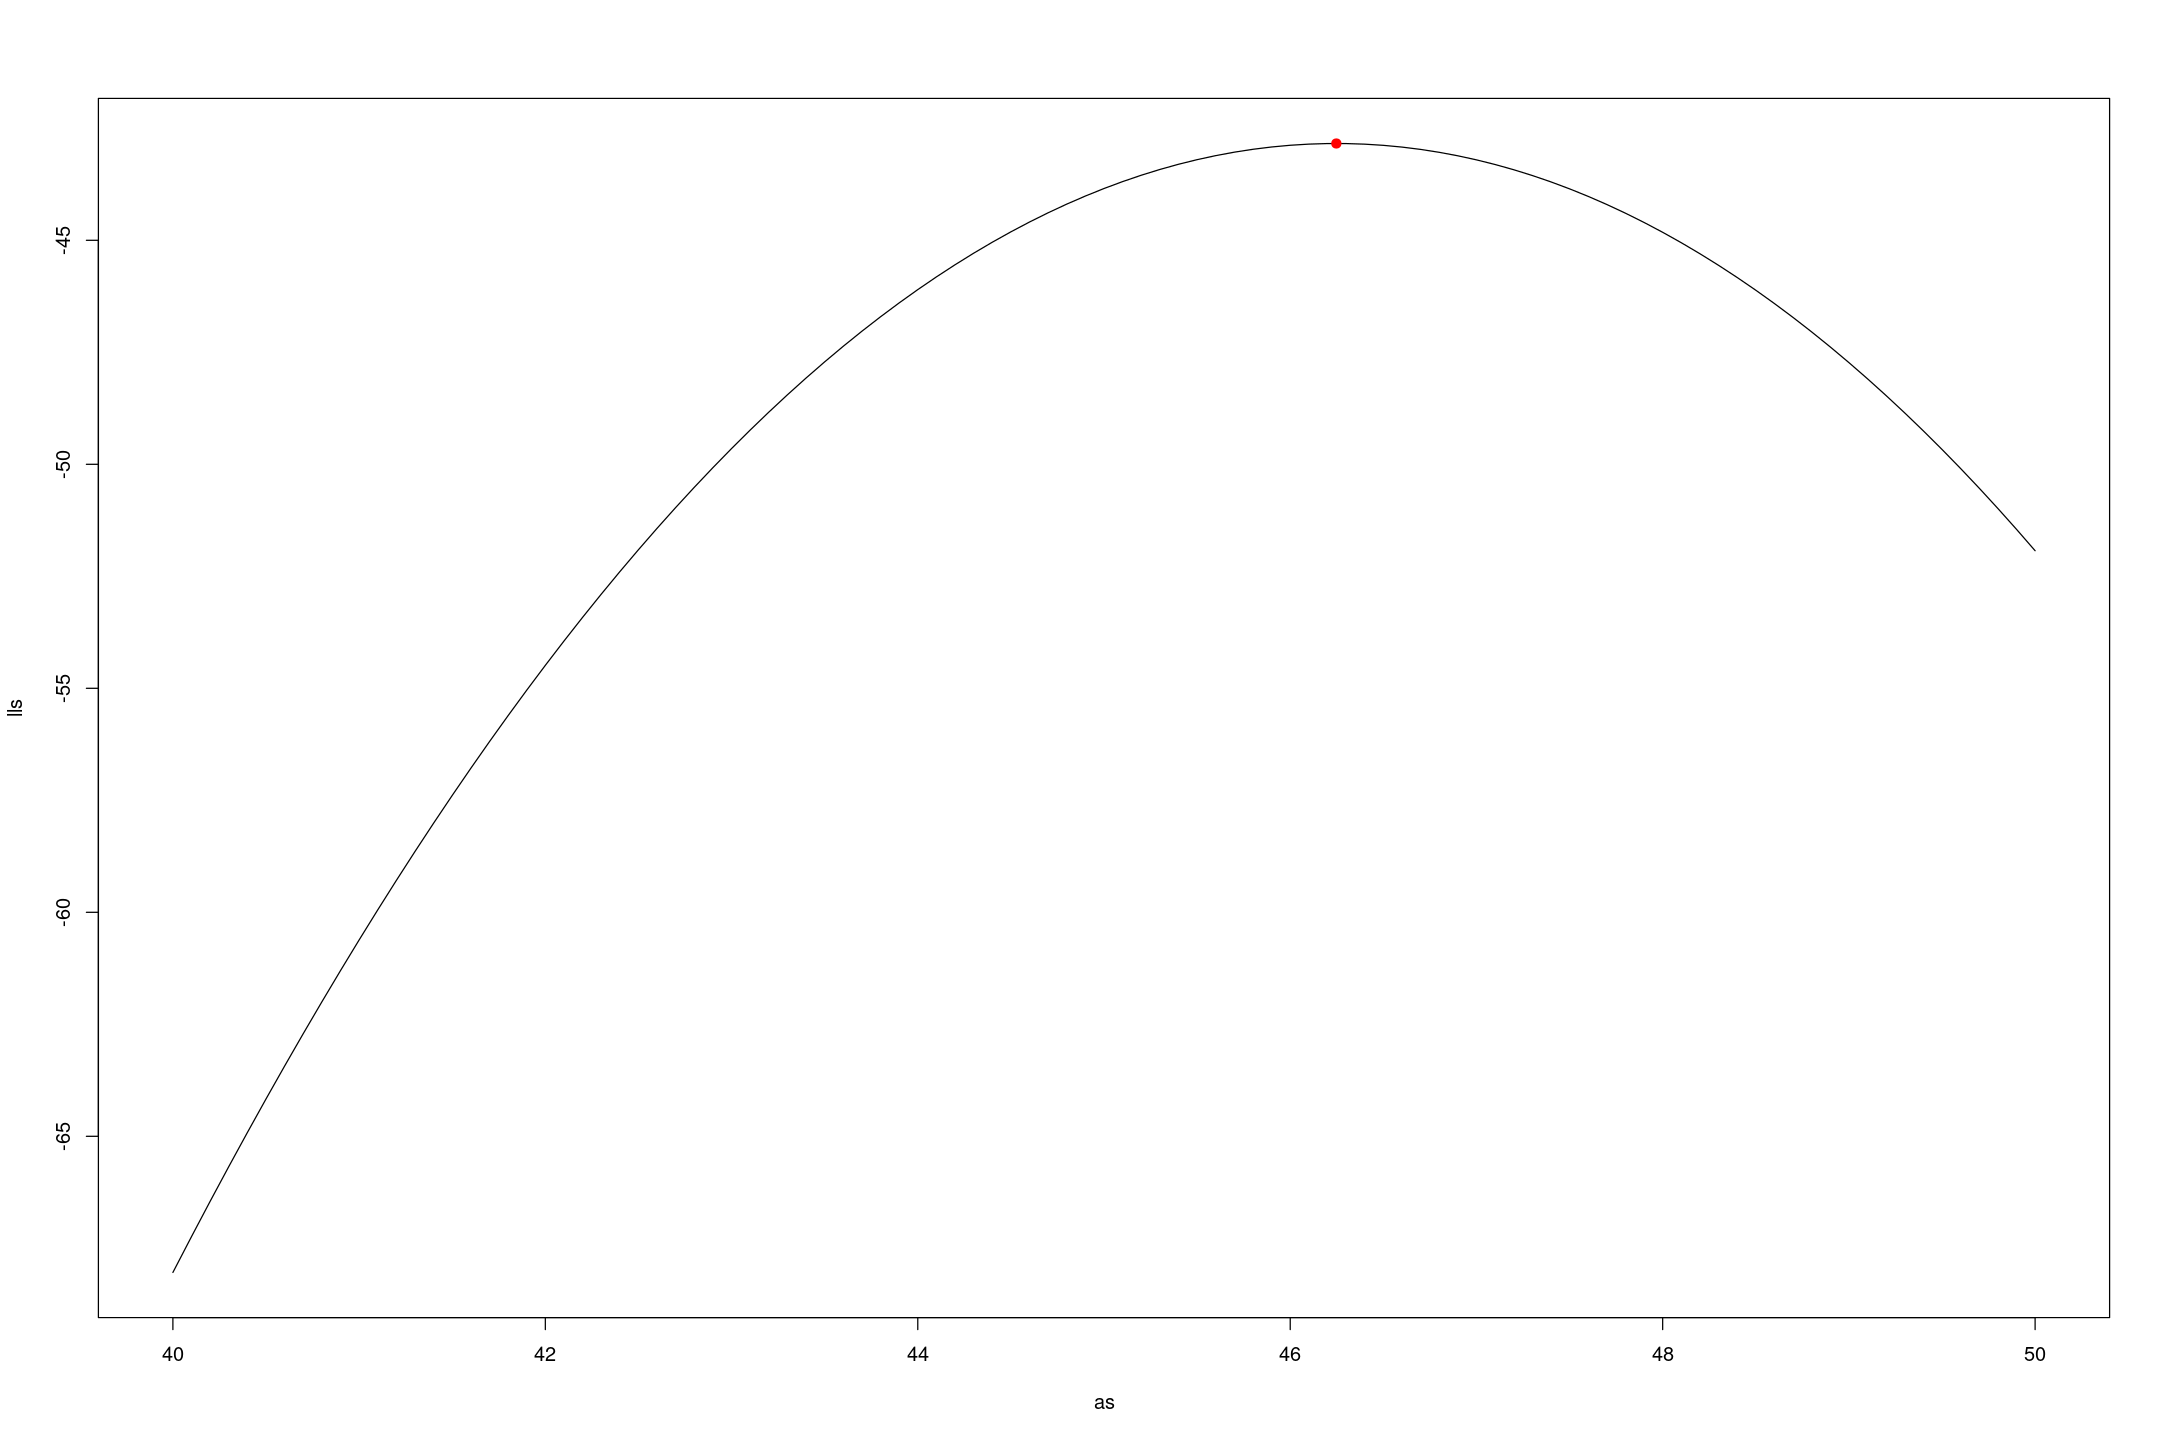

In [20]:
as <- seq(40, 50, by=0.1)
lls <- vapply(as, function (x) normal_logliklihood(hibbs$growth, hibbs$vote, x, b_min, s_min), double(1))
plot(as, lls, type='l')
points(a_min, max_ll, pch=19, col='red')

The minimum is very near what we expect

In [21]:
c(as[which.max(lls)], a_min)

[1] 46.20000 46.24765

## Check along b

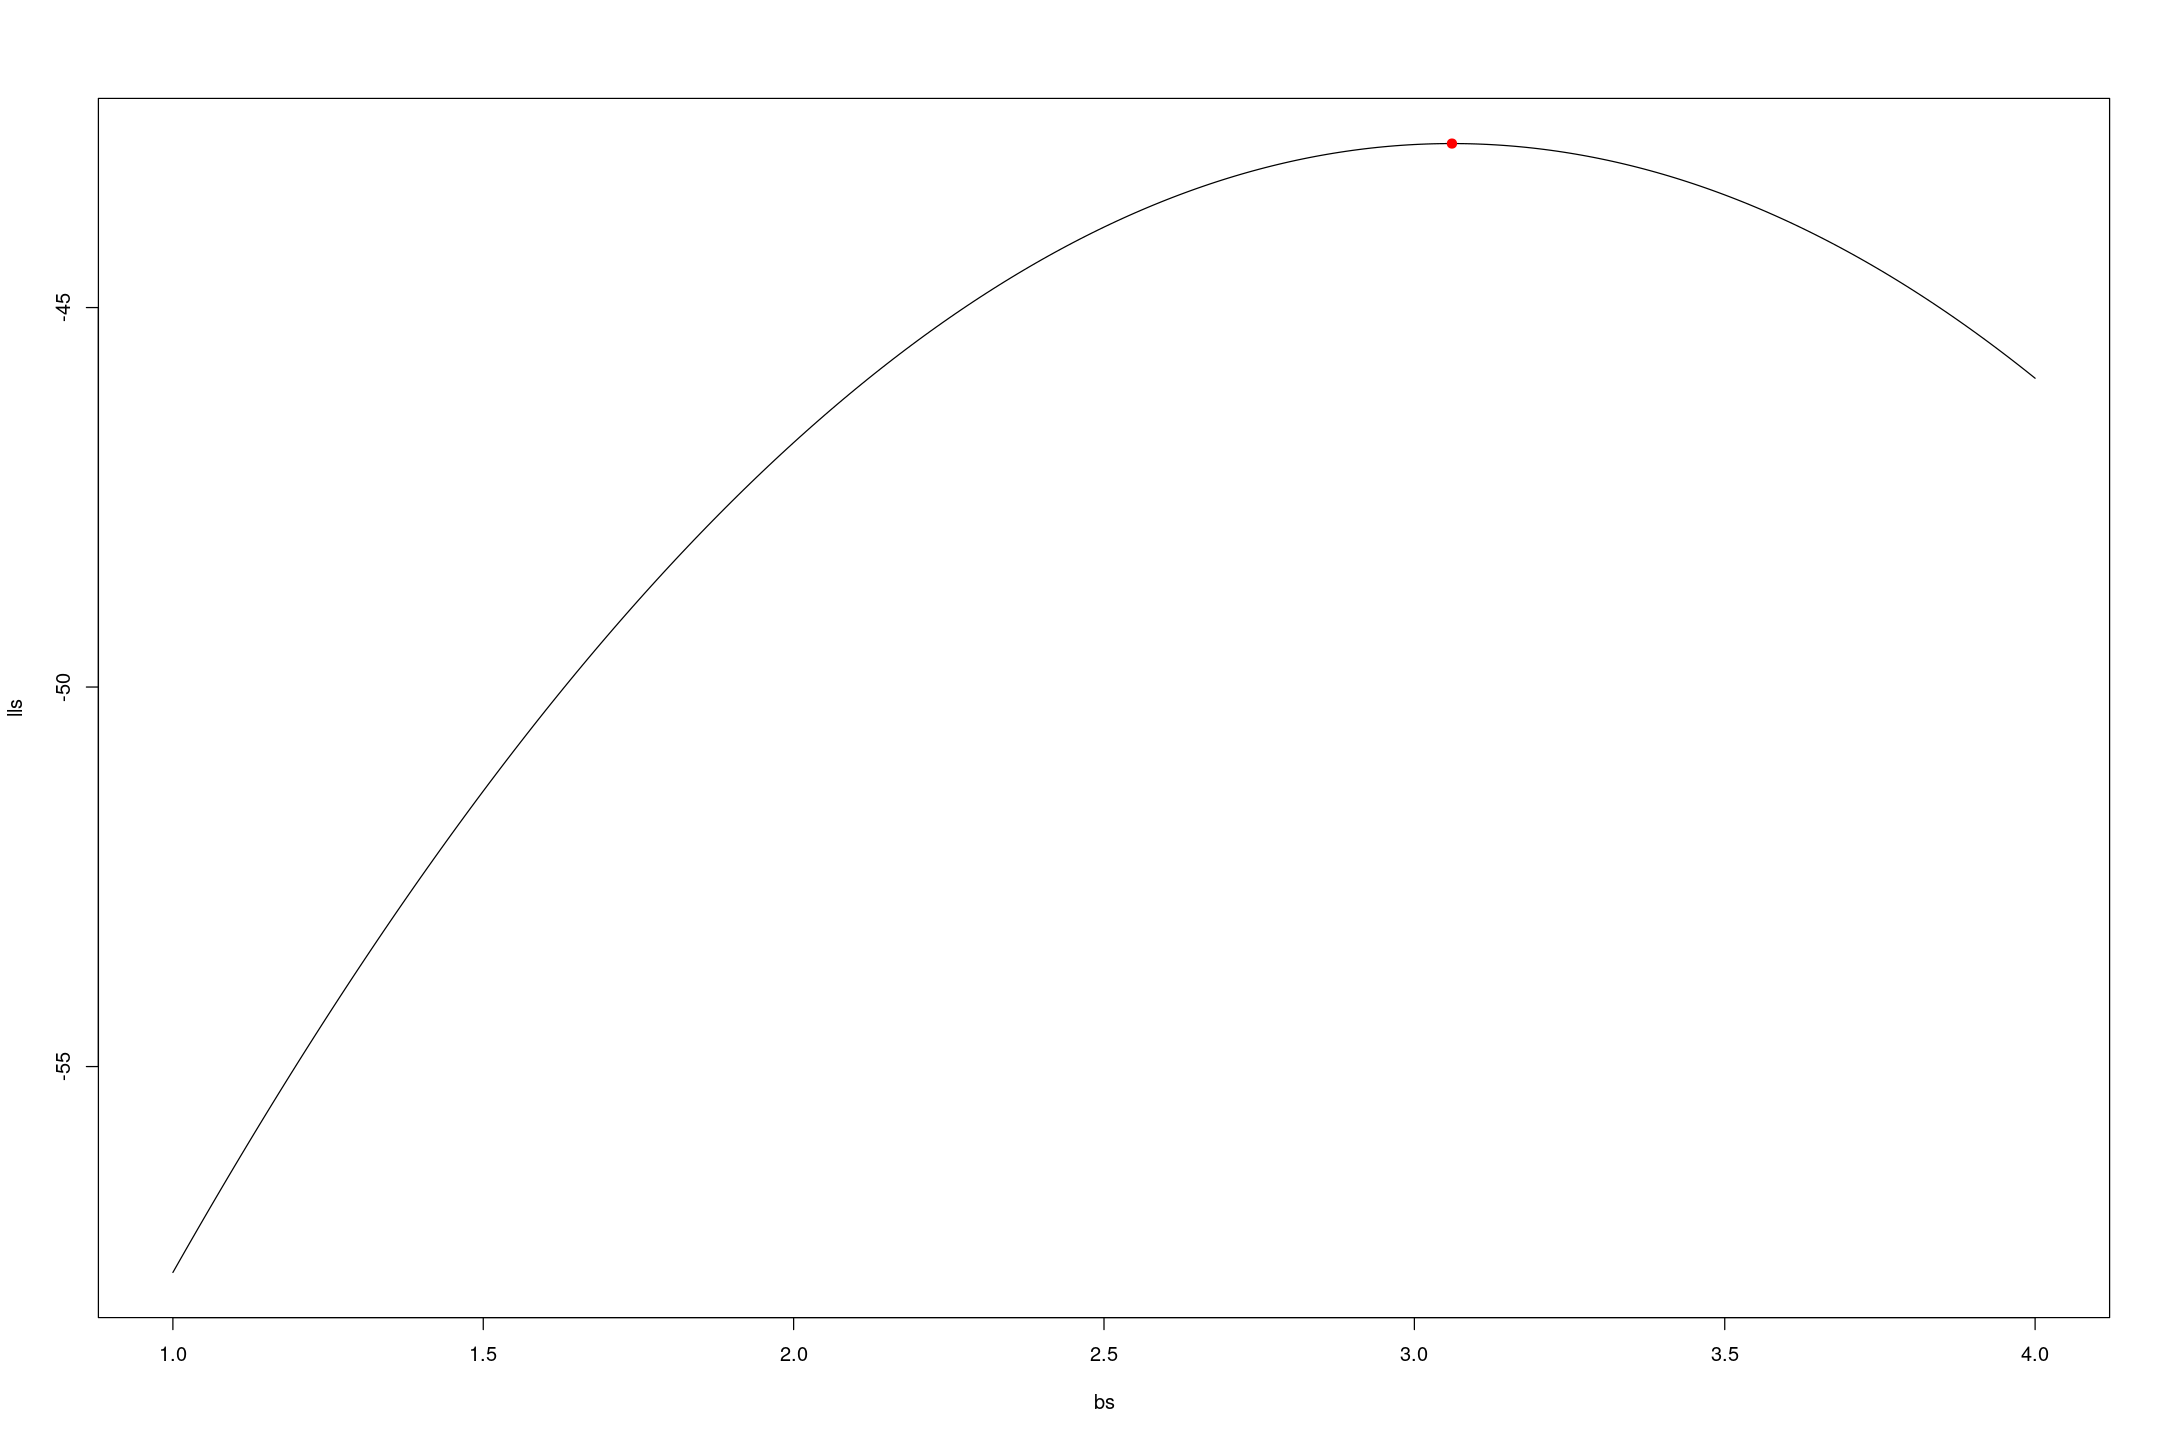

In [22]:
bs <- seq(1, 4, by=0.01)
lls <- vapply(bs, function (x) normal_logliklihood(hibbs$growth, hibbs$vote, a_min, x, s_min), double(1))
plot(bs, lls, type='l')
points(b_min, max_ll, pch=19, col='red')

It's pretty close to what we expect the extremum to be

In [23]:
c(bs[which.max(lls)], b_min)

[1] 3.060000 3.060528

## Sigma

Notice if we use the estimate that corrects for overfitting it doesn't maximise loglikelihood

In [24]:
s_min_adjusted = (1/(length(y)-2) * sum((y - (a_min + b_min * x))^2))^(1/2)
s_min_adjusted

[1] 3.763288

In [25]:
s_adjusted_ll <- normal_logliklihood(hibbs$growth, hibbs$vote, a_min, b_min, s_min_adjusted)
c(s_adjusted_ll, max_ll)

[1] -42.90770 -42.83945

### Plotting

We can see that the curve is a lot less steep, and so there's going to be more uncertainty in sigma

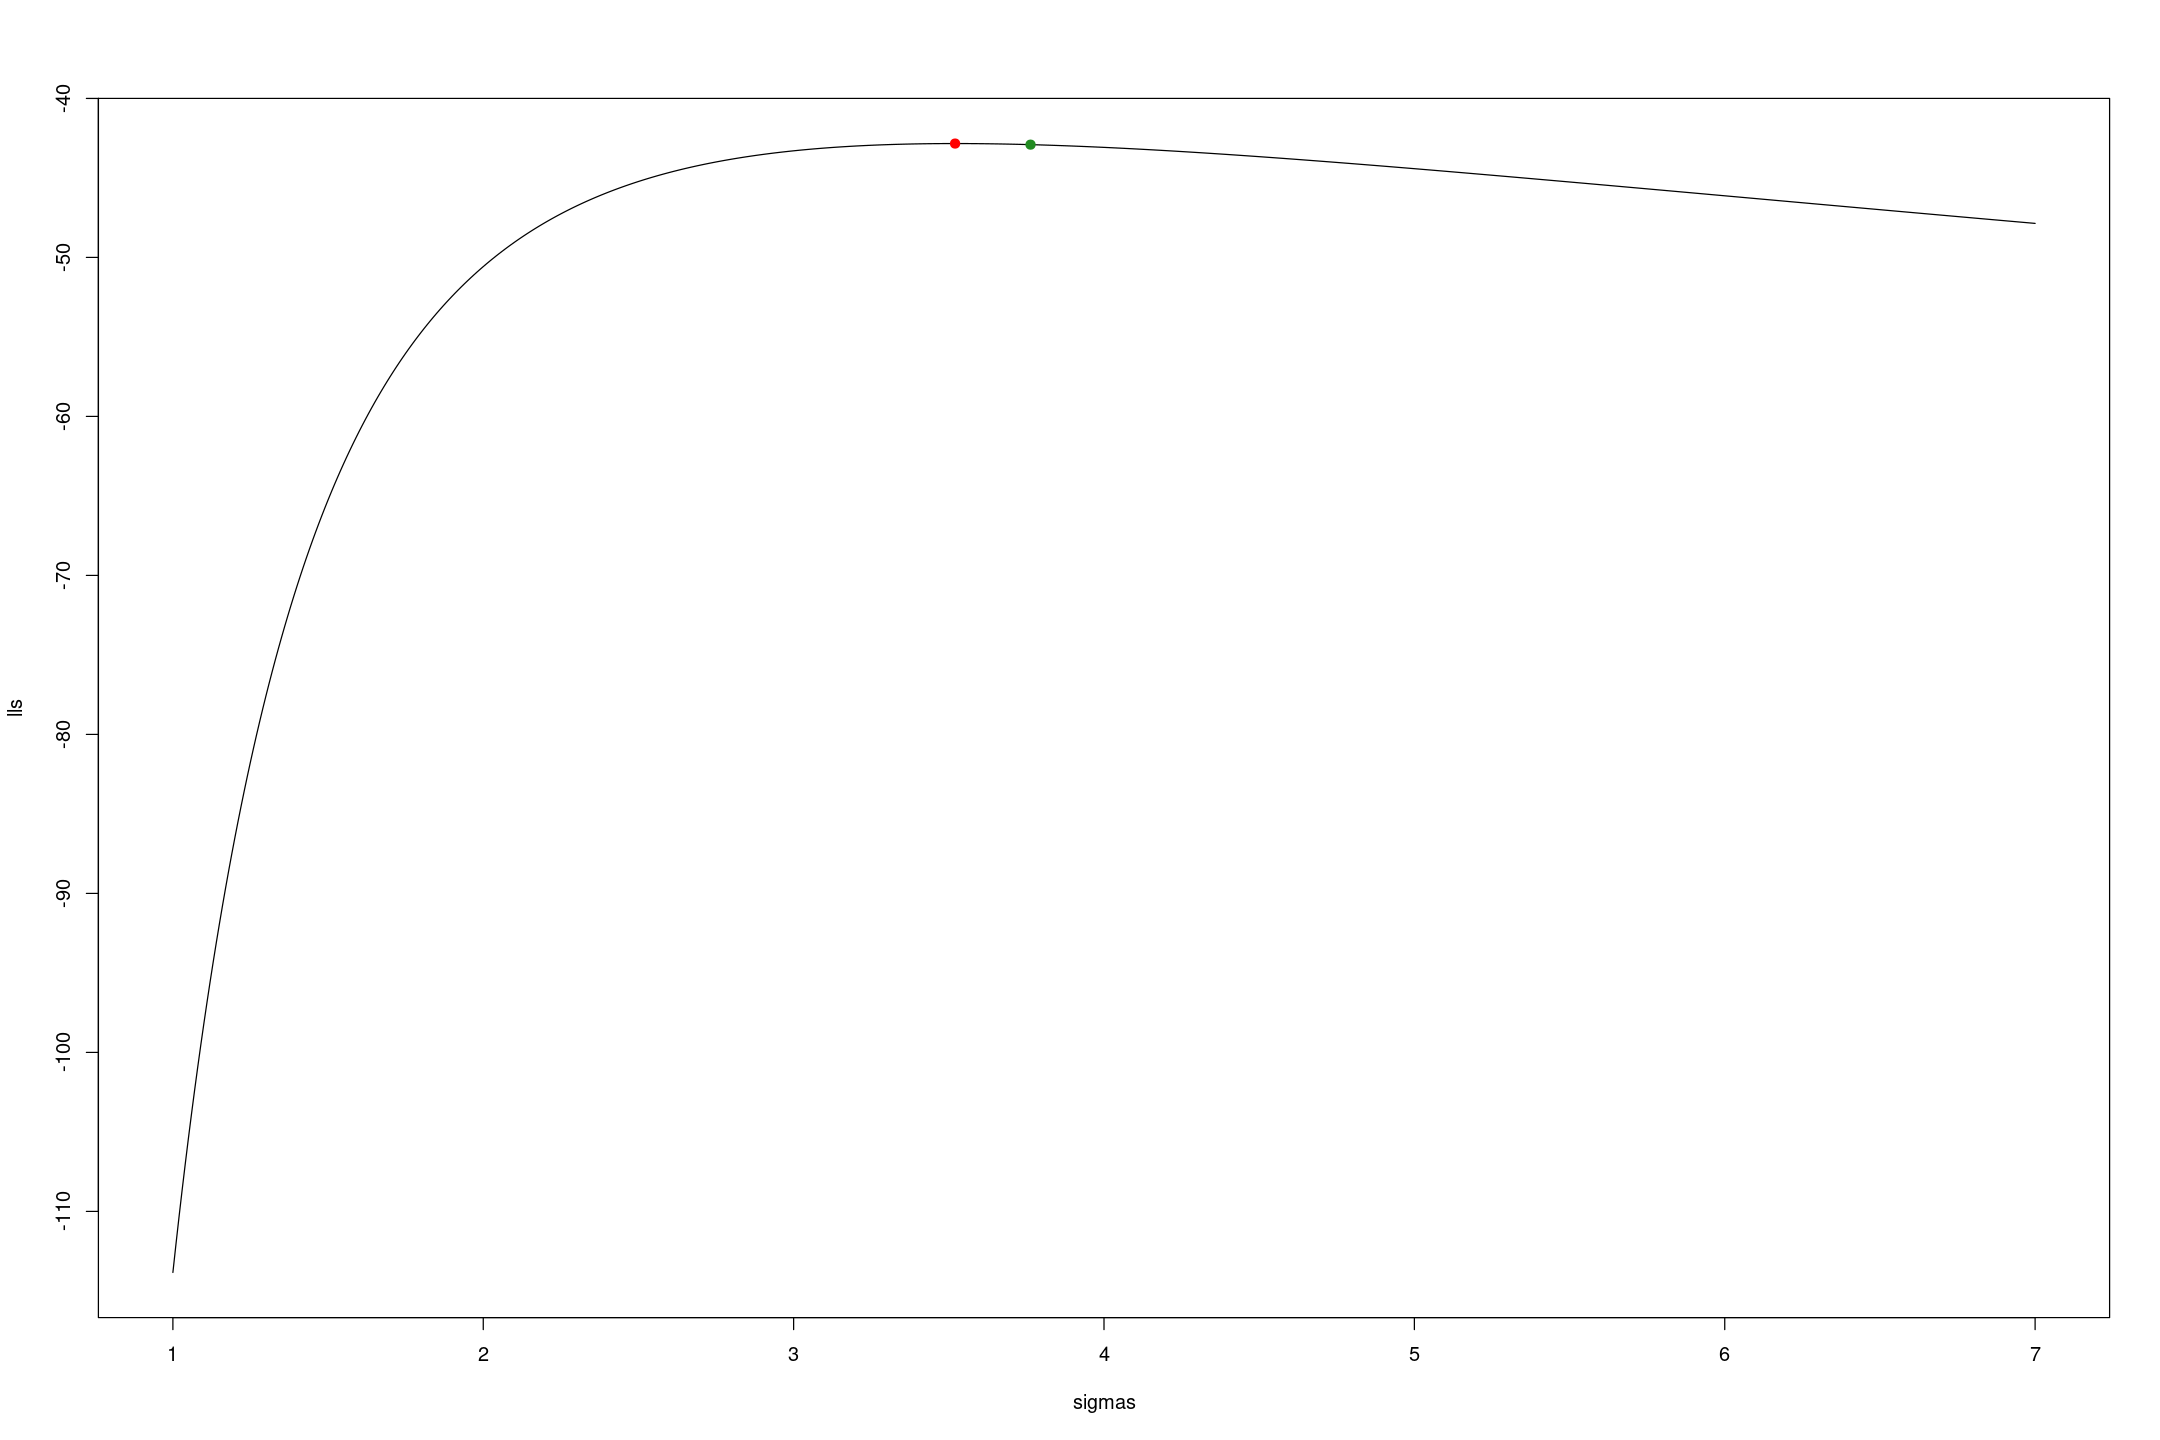

In [26]:
sigmas <- seq(1, 7, by=0.01)
lls <- vapply(sigmas, function (x) normal_logliklihood(hibbs$growth, hibbs$vote, a_min, b_min, x), double(1))
plot(sigmas, lls, type='l')
points(s_min, max_ll, pch=19, col='red')
points(s_min_adjusted, s_adjusted_ll, pch=19, col='forestgreen')

In [27]:
c(sigmas[which.max(lls)], s_min)

[1] 3.520000 3.520233

In [28]:
s_min_adjusted

[1] 3.763288

# Least absolute deviation
Repeat 8.1, but instead of calculating and minimizing the sum of squares of residuals, do this for the sum of absolute values of residuals.
Find the $(a, b)$ that minimizes the sum of absolute values of residuals, and plot the sum of absolute values of residuals as a function of a and of b.
Compare the least squares and least absolute deviation estimates of $(a, b)$.

# Least squares and least abolute deviation
Construct a set of data $(x, y)_i,\ i = 1,\ldots,n$, for which the least squares and least absolute deviation estimates of $(a, b)$ in the fit, $ y = a + bx$, are much different.
What did you have to do to make this happen?

# Influence of individual data points
A linear regression is fit to the data below.
Which point has the most influence on the slope.

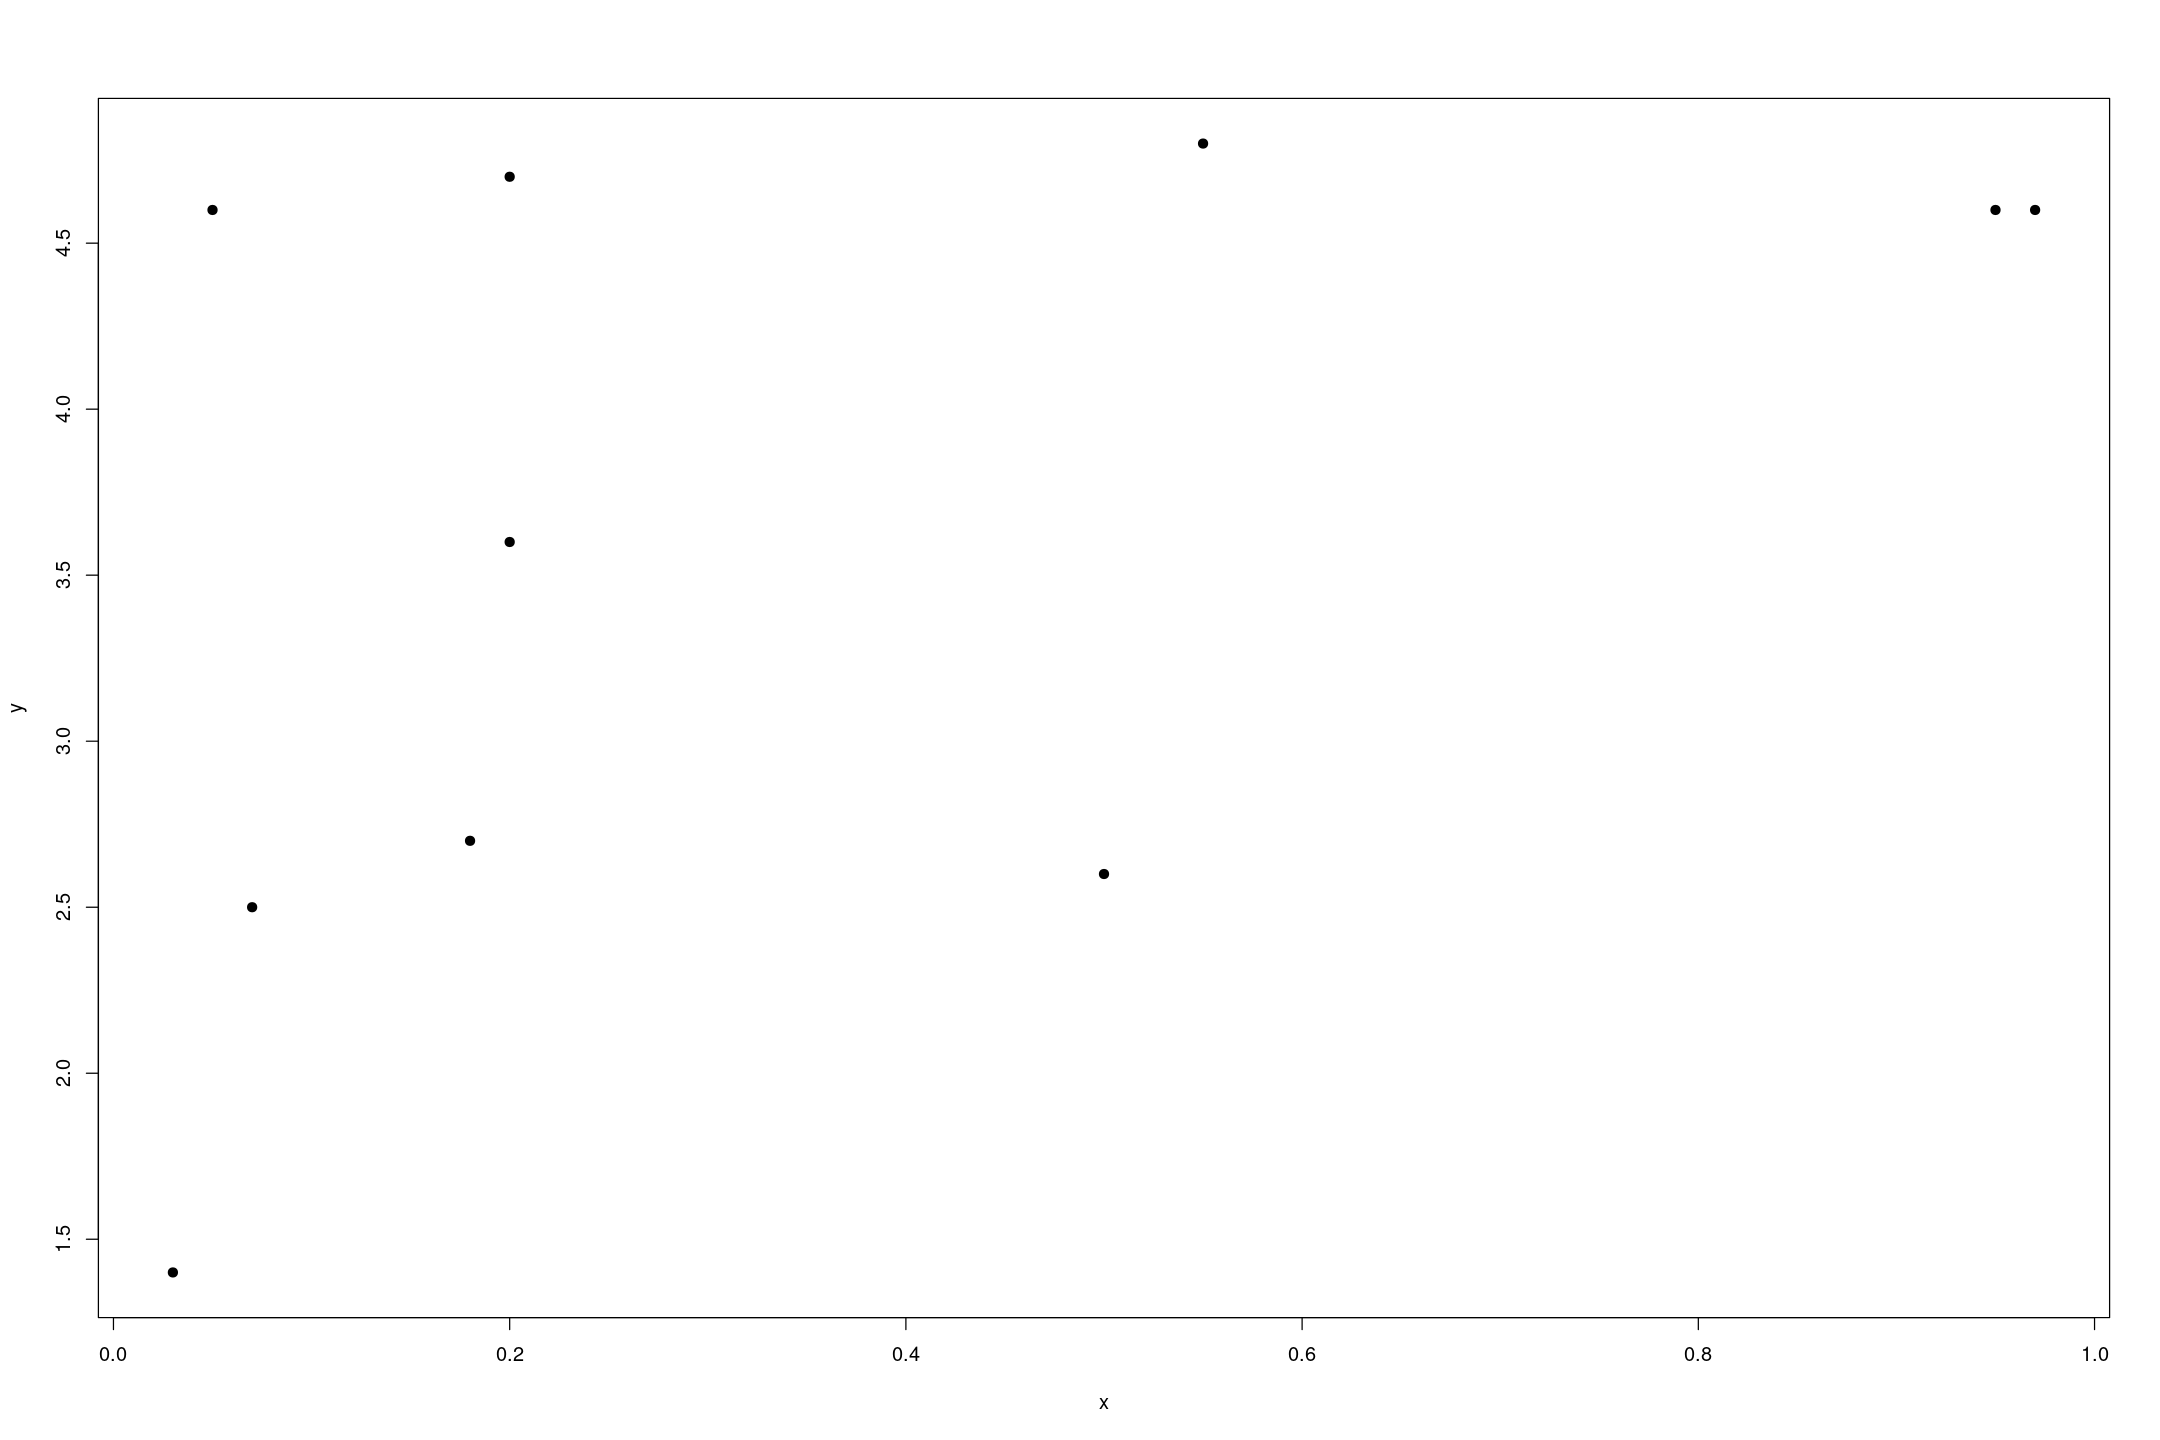

In [29]:
scatters <- tribble(
  ~x, ~y,
  0.03, 1.4,
  0.05, 4.6,
  0.07, 2.5,
  0.18, 2.7,
    0.2, 3.6,
    0.2, 4.7,
    0.5, 2.6,
    0.55, 4.8,
    0.95, 4.6,
    0.97, 4.6
    )

plot(scatters, pch=19)

# Influence of individual data points

a) Using expression (8.3), compute the influence of each of the data points in the election forecasting example on the fitted slope of the model.
Make a graph plotting influence of point $i$ vs. $x_i$.

b) Re-fit the model $n$ times, for each data point $i$ adding 1 to $y_i$.
Save $\hat{b}$ from each of these altered regressions, compare to the $\hat{b}$ from the original data, and check that the influence is approximately the same as computed above using the formula.
(The two calculations will not exactly give identical results because `stan_glm` uses a prior distribution and so it does not exactly yield the least squares estimate.)

# Least squares slope as a weighted average of individual slopes

a) Prove that the weighted average slope defined in equation (8.8) is equivalent to the least squares regression slope in equation (8.3).

b) Demonstrate how this works in a simple case with three data points, $(x, y) = (0,0), (4, 1), (5,5)$.

# Comparing `lm` and `stan_glm`
Use simulated data to compare least squares estimation to default Bayesian regression.

a) Simulate 100 data points from the model, $y = 2 + 3x + \rm{error}$, with predictors x drawn from a uniform distribution from 0 to 20, and with independent errors drawn from the normal distribution with mean 0 and standard deviation 5.
Fit the regression of y on x data using `lm` and `stan_glm` (using its default settings) and check that the two programs give nearly identical results.

b) Plot the simulated data and the two fitted regression lines.

c) Repeat the two steps above but try to create conditions for your simulation so that `lm` and `stan_glm` give much different results.

# Leave-one-out cross validation

# Leave-one-out cross validation